In [1]:
from fenics import *
import numpy as np
import matplotlib.pyplot as plt
from sbi.utils import BoxUniform
import pandas as pd
import torch

set_log_level(30)

/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/home/sam/miniconda3/envs/fenics-sbi-env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
g = 9.81
R = 287.0
T_gas = 300.0
L = 10.0
N = 200
T= 5.0

mesh = IntervalMesh(N, 0, L)


dx_cell = L / N
CFL = 0.05

cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

def two_phase_simulator(theta, T=10.0, N=200, L=10.0, seed=None, return_full=False):
    """
    theta: [C_wall_L, C_wall_G, C_int, theta_incline]
    Returns:
        (timesteps+1, N) array of alpha_L, or optionally all fields.
    """
    # Unpack
    C_wall_L, C_wall_G, C_int, theta_pipe = theta

    rho_L = 800
    rho_G = 1.2

    if seed is not None:
        np.random.seed(seed)


    # Initial holdup and velocity profiles
    V = FunctionSpace(mesh, "DG", 0)
    x = SpatialCoordinate(mesh)
    alpha_L0 = project(0.5 + 0.15 * sin(2 * np.pi * x[0] / L), V)
    alpha_G0 = project(1.0 - (0.5 + 0.15 * sin(2 * np.pi * x[0] / L)), V)


    u_L0 = 1.0 + .2 * np.sin(np.pi * cell_centers / L)
    u_G0 = 2.0 + .1 * np.cos(np.pi * cell_centers / L)

    dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
    timesteps = int(T / dt)

    alpha_L_n = Function(V)
    alpha_G_n = Function(V)
    alpha_L_n.assign(alpha_L0)
    alpha_G_n.assign(alpha_G0)
    u_L_n = u_L0.copy()
    u_G_n = u_G0.copy()

    all_data_L = np.zeros((timesteps+1, V.dim()))
    all_data_G = np.zeros((timesteps+1, V.dim()))
    all_data_uL = np.zeros((timesteps+1, V.dim()))
    all_data_uG = np.zeros((timesteps+1, V.dim()))
    all_data_L[0, :] = alpha_L_n.vector().get_local()
    all_data_G[0, :] = alpha_G_n.vector().get_local()
    all_data_uL[0, :] = u_L_n
    all_data_uG[0, :] = u_G_n

    def compute_geometries(alpha):
        r = 0.05
        h_int = np.clip(r * (2 * alpha - 1), -r + 1e-8, r - 1e-8)
        r2 = r * r
        root_h = np.sqrt(r2 - h_int**2)
        A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
        A_G = r2 * np.arccos(h_int/r) - h_int * root_h
        P_LG = 2 * root_h
        P_LW = 2 * r * np.arccos(-h_int/r)
        P_GW = 2 * r * np.arccos(h_int/r)
        return h_int, A_L, A_G, P_LG, P_LW, P_GW

    for step in range(1, timesteps+1):
        alpha_L = alpha_L_n.vector().get_local()
        alpha_G = alpha_G_n.vector().get_local()
        u_L = u_L_n.copy()
        u_G = u_G_n.copy()

        # Geometry
        h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L)
        p_int = np.full_like(alpha_L, rho_G * R * T_gas)
        # Hydrostatic pressure (linear)
        p_av_L = p_int + rho_L * g * (h_int) * np.sin(theta_pipe)
        p_av_G = p_int + rho_G * g * (h_int) * np.sin(theta_pipe)
        # Pressure gradients
        p_grad_L = np.zeros_like(p_av_L)
        p_grad_G = np.zeros_like(p_av_G)
        p_grad_L[1:-1] = (p_av_L[2:] - p_av_L[:-2]) / (2 * dx_cell)
        p_grad_G[1:-1] = (p_av_G[2:] - p_av_G[:-2]) / (2 * dx_cell)
        p_grad_L[0] = (p_av_L[1] - p_av_L[0]) / dx_cell
        p_grad_L[-1] = (p_av_L[-1] - p_av_L[-2]) / dx_cell
        p_grad_G[0] = (p_av_G[1] - p_av_G[0]) / dx_cell
        p_grad_G[-1] = (p_av_G[-1] - p_av_G[-2]) / dx_cell

        # --- ADVECT HOLDUPS (Upwind FV) ---
        F_L = np.zeros_like(alpha_L)
        F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
        F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        F_L_left = np.zeros_like(alpha_L)
        F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
        F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

        F_G = np.zeros_like(alpha_G)
        F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
        F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        F_G_left = np.zeros_like(alpha_G)
        F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
        F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

        # --- MOMENTUM (Upwind FV + drag + pressure/grav) ---
        m_L = alpha_L * rho_L * u_L
        Fm_L = np.zeros_like(m_L)
        Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:] * rho_L
        Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        Fm_L_left = np.zeros_like(m_L)
        Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1] * rho_L
        Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        
        gravity_L = A_L * rho_L * g * np.sin(theta_pipe)
        m_L_new = m_L \
                  - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
                  - dt * C_wall_L * m_L \
                  + dt * C_int * alpha_L * rho_L * (u_G - u_L) \
                  - dt * A_L * p_grad_L \
                  + dt * gravity_L
                  
        u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new * rho_L + 1e-12), 0.0)

        m_G = alpha_G * rho_G * u_G
        Fm_G = np.zeros_like(m_G)
        Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:] * rho_G
        Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G
        Fm_G_left = np.zeros_like(m_G)
        Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1] * rho_G
        Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G


        gravity_G = A_G * rho_G * g * np.sin(theta_pipe)

        m_G_new = m_G \
                  - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
                  - dt * C_wall_G * m_G \
                  - dt * C_int * alpha_G * rho_G * (u_G - u_L) \
                  - dt * A_G * p_grad_G \
                  + dt * gravity_G

        u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new * rho_G + 1e-12), 0.0)

        # --- ENFORCE CLOSURE ---
        sum_holdup = alpha_L_new + alpha_G_new
        alpha_L_new /= (sum_holdup + 1e-12)
        alpha_G_new /= (sum_holdup + 1e-12)

        # Save and update
        alpha_L_n.vector().set_local(alpha_L_new)
        alpha_G_n.vector().set_local(alpha_G_new)
        u_L_n = u_L_new
        u_G_n = u_G_new
        all_data_L[step, :] = alpha_L_new
        all_data_G[step, :] = alpha_G_new
        all_data_uL[step, :] = u_L_new
        all_data_uG[step, :] = u_G_new

    if return_full:
        return all_data_L, all_data_G, all_data_uL, all_data_uG, timesteps
    else:
        return all_data_L, timesteps

In [4]:
def enriched_summary(alpha_L, alpha_G, u_L, u_G):
    # Each: shape = [timesteps+1, N]
    stats = []

    for field in [alpha_L, alpha_G, u_L, u_G]:
        # 1. Time-domain features
        mean_t = field.mean(axis=1)       # spatial mean at each time
        std_t  = field.std(axis=1)        # spatial std at each time

        stats.append(mean_t[0])           # initial spatial mean
        stats.append(mean_t[-1])          # final spatial mean
        stats.append(mean_t.max())        # max spatial mean
        stats.append(mean_t.min())        # min spatial mean
        stats.append(mean_t.mean())       # mean of spatial mean

        stats.append(std_t[0])            # initial spatial std
        stats.append(std_t[-1])           # final spatial std
        stats.append(std_t.max())         # max spatial std
        stats.append(std_t.mean())        # mean spatial std

        stats.append(field.min())         # min overall
        stats.append(field.max())         # max overall
        stats.append(field.mean())        # mean overall
        stats.append(field.std())         # std overall

        # 2. Step/transient features
        diff_t = np.diff(mean_t)
        stats.append(diff_t.max())        # max increase
        stats.append(diff_t.min())        # max decrease

        # 3. Frequency features (use only if enough timesteps)
        if mean_t.shape[0] > 8:
            fft_vals = np.abs(np.fft.rfft(mean_t - mean_t.mean()))
            stats.append(fft_vals[1:8].max())  # largest peak, skip DC
            stats.append(fft_vals[1:8].argmax())  # peak freq index

    # 4. Cross-field correlations
    fields = [alpha_L, alpha_G, u_L, u_G]
    means = [f.mean(axis=1) for f in fields]
    for i in range(4):
        for j in range(i+1, 4):
            corr = np.corrcoef(means[i], means[j])[0,1]
            stats.append(corr)

    # 5. Differences between paired fields
    stats.append(np.mean(u_L - u_G))
    stats.append(np.max(u_L - u_G))
    stats.append(np.mean(alpha_L - alpha_G))
    stats.append(np.max(alpha_L - alpha_G))

    # 6. Spatial features at key times
    for idx in [0, -1, len(alpha_L)//2]:
        for field in fields:
            stats.append(field[idx].mean())  # spatial mean at key time
            stats.append(field[idx].std())   # spatial std at key time

    return np.array(stats, dtype=np.float32)


def enriched_summary_with_pressure(alpha_L, alpha_G, u_L, u_G, theta_pipe, rho_L, rho_G):
    # Usual field statistics
    stats = []
    for field in [alpha_L, alpha_G, u_L, u_G]:
        mean_t = field.mean(axis=1)
        std_t = field.std(axis=1)
        stats.append(mean_t[0])
        stats.append(mean_t[-1])
        stats.append(mean_t.max())
        stats.append(mean_t.min())
        stats.append(mean_t.mean())
        stats.append(std_t[0])
        stats.append(std_t[-1])
        stats.append(std_t.max())
        stats.append(std_t.mean())
        stats.append(field.min())
        stats.append(field.max())
        stats.append(field.mean())
        stats.append(field.std())
        diff_t = np.diff(mean_t)
        stats.append(diff_t.max())
        stats.append(diff_t.min())
        if mean_t.shape[0] > 8:
            fft_vals = np.abs(np.fft.rfft(mean_t - mean_t.mean()))
            stats.append(fft_vals[1:8].max())
            stats.append(fft_vals[1:8].argmax())
    # Cross correlations and differences (as before)
    fields = [alpha_L, alpha_G, u_L, u_G]
    means = [f.mean(axis=1) for f in fields]
    for i in range(4):
        for j in range(i+1, 4):
            corr = np.corrcoef(means[i], means[j])[0,1]
            stats.append(corr)
    stats.append(np.mean(u_L - u_G))
    stats.append(np.max(u_L - u_G))
    stats.append(np.mean(alpha_L - alpha_G))
    stats.append(np.max(alpha_L - alpha_G))
    for idx in [0, -1, len(alpha_L)//2]:
        for field in fields:
            stats.append(field[idx].mean())
            stats.append(field[idx].std())

    # --- NEW: PRESSURE AND PRESSURE GRADIENTS ---
    # Compute h_int as in your simulator
    r = 0.05
    h_int = np.clip(r * (2 * alpha_L - 1), -r + 1e-8, r - 1e-8)
    p_int = np.full_like(alpha_L, rho_G * 287.0 * 300.0)
    p_av_L = p_int + rho_L * 9.81 * h_int * np.sin(theta_pipe)
    p_av_G = p_int + rho_G * 9.81 * h_int * np.sin(theta_pipe)
    # Compute spatial gradient at each time step (axis=1)
    dx = 10.0 / alpha_L.shape[1]
    p_grad_L = np.gradient(p_av_L, dx, axis=1)
    p_grad_G = np.gradient(p_av_G, dx, axis=1)
    # Add pressure gradient stats at initial, middle, final timestep
    for idx in [0, -1, alpha_L.shape[0]//2]:
        stats.append(p_grad_L[idx].mean())
        stats.append(p_grad_L[idx].std())
        stats.append(p_grad_G[idx].mean())
        stats.append(p_grad_G[idx].std())
    # Add overall mean/std
    stats.append(p_grad_L.mean())
    stats.append(p_grad_L.std())
    stats.append(p_grad_G.mean())
    stats.append(p_grad_G.std())

    return np.array(stats, dtype=np.float32)


In [5]:
def run_sensitivity_analysis(
        theta_base,
        two_phase_simulator,
        enriched_summary,
        param_names=None,
        delta_frac=0.10,
        sim_kwargs=None,
        normalize_stats=True,
        verbose=True,
        random_seed=42
    ):
    """
    Runs one-at-a-time local sensitivity analysis.
    
    Parameters:
        theta_base: np.array, base parameter vector
        two_phase_simulator: function(theta, **sim_kwargs) -> tuple of fields (alpha_L, alpha_G, u_L, u_G, ...)
        enriched_summary: function(alpha_L, alpha_G, u_L, u_G) -> 1D array of summary stats
        param_names: list of parameter names (for printout)
        delta_frac: fractional perturbation size (default 10%)
        sim_kwargs: dict, additional arguments to pass to simulator
        normalize_stats: if True, standardize each summary feature by baseline std
        verbose: if True, prints progress and table
        random_seed: for reproducibility

    Returns:
        sensitivities: list of (param_name, avg_sens, diff_up, diff_down)
        sensitivity_vector: np.array of sensitivities (avg_sens)
    """
    if sim_kwargs is None:
        sim_kwargs = {}
    if param_names is None:
        param_names = [f"param_{i}" for i in range(len(theta_base))]

    # Fix seed for reproducibility
    if 'seed' in sim_kwargs:
        sim_kwargs['seed'] = random_seed

    # Run baseline simulation
    base_fields = two_phase_simulator(theta_base, return_full=True, **sim_kwargs)
    base_stats = enriched_summary(*base_fields[:4])

    # Optionally normalize stats features (per feature z-score)
    stat_mean = base_stats.mean()
    stat_std = base_stats.std()
    if normalize_stats:
        def norm(x): return (x - stat_mean) / (stat_std + 1e-12)
        base_stats = norm(base_stats)
    else:
        def norm(x): return x

    sensitivities = []
    N = len(theta_base)

    for i in range(N):
        theta_up = theta_base.copy()
        theta_down = theta_base.copy()
        theta_up[i] *= (1 + delta_frac)
        theta_down[i] *= (1 - delta_frac)

        # Simulate + perturbation
        fields_up = two_phase_simulator(theta_up, return_full=True, **sim_kwargs)
        stats_up = enriched_summary(*fields_up[:4])
        stats_up = norm(stats_up)

        # Simulate - perturbation
        fields_down = two_phase_simulator(theta_down, return_full=True, **sim_kwargs)
        stats_down = enriched_summary(*fields_down[:4])
        stats_down = norm(stats_down)

        # L2 norm of summary difference
        diff_up = np.linalg.norm(stats_up - base_stats)
        diff_down = np.linalg.norm(stats_down - base_stats)
        avg_sens = 0.5 * (diff_up + diff_down)

        sensitivities.append((param_names[i], avg_sens, diff_up, diff_down))

        if verbose:
            print(f"{param_names[i]:<20s}  avg_sens={avg_sens:8.4f}  up={diff_up:8.4f}  down={diff_down:8.4f}")

    if verbose:
        print("\nSensitivity ranking (highest first):")
        for i, (p, s, _, _) in sorted(enumerate(sensitivities), key=lambda x: -x[1][1]):
            print(f"{sensitivities[i][0]:<20s}: {sensitivities[i][1]:.4f}")

    sensitivity_vector = np.array([s[1] for s in sensitivities])
    return sensitivities, sensitivity_vector

In [5]:
param_names = ['C_wall_L', 'C_wall_G', 'C_int', 'theta_incline']
theta_base = np.array([1., 0.05, 0.02, 0.4])

# def summary_func(alpha_L, alpha_G, u_L, u_G, *args, **kwargs):
#     # Pull theta_pipe, rho_L, rho_G from kwargs if needed
#     # Or pass through global config, or have your simulator output these as well
#     # For now, let's assume you always want to use the same values:
#     return enriched_summary_with_pressure(
#         alpha_L, alpha_G, u_L, u_G,
#         theta_pipe=kwargs.get('theta_pipe', 0.4),
#         rho_L=kwargs.get('rho_L', 1000.0),
#         rho_G=kwargs.get('rho_G', 1.2)
#     )


sensitivities, sensitivity_vector = run_sensitivity_analysis(
    theta_base=theta_base,
    two_phase_simulator=two_phase_simulator,
    enriched_summary=enriched_summary,
    param_names=param_names,
    delta_frac=0.10,
    sim_kwargs={'T': 5.0, 'N': 200, 'L': 10.0},
    normalize_stats=True,
    verbose=True
)

C_wall_L              avg_sens=  0.2735  up=  0.2857  down=  0.2614
C_wall_G              avg_sens=  0.4344  up=  0.4293  down=  0.4394
C_int                 avg_sens=  0.1634  up=  0.1624  down=  0.1644
theta_incline         avg_sens=  0.1390  up=  0.1378  down=  0.1402

Sensitivity ranking (highest first):
C_wall_G            : 0.4344
C_wall_L            : 0.2735
C_int               : 0.1634
theta_incline       : 0.1390


In [12]:
param_names = ['C_wall_L', 'C_wall_G', 'C_int', 'theta_incline']

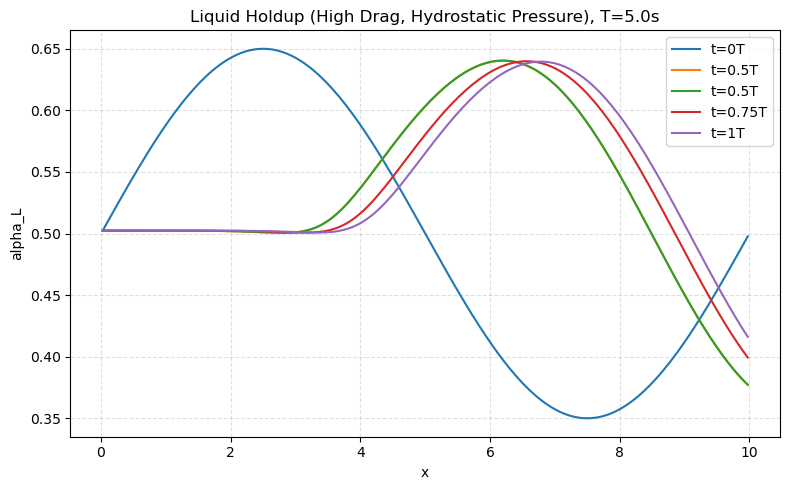

In [6]:
theta_test = np.array([1, 1, 1, 0.8])
all_data_L, timesteps = two_phase_simulator(theta_test, T=5.0, N=200, L=10.0)

plt.figure(figsize=(8, 5))
time_fractions = [0, 0.5, 0.5, 0.75, 1.0]
labels = [f't={frac:.2g}T' for frac in time_fractions]
for frac, label in zip(time_fractions, labels):
    idx = int(frac * timesteps)
    plt.plot(cell_centers, all_data_L[idx, :], label=label)
plt.xlabel('x')
plt.ylabel('alpha_L')
plt.legend()
plt.title(f"Liquid Holdup (High Drag, Hydrostatic Pressure), T={T}s")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

In [7]:
def simulator_wrapper(theta):
    alpha_L, alpha_G, u_L, u_G, _ = two_phase_simulator(theta, return_full=True)
    return torch.tensor(enriched_summary(alpha_L, alpha_G, u_L, u_G), dtype=torch.float32)


In [8]:
prior_low  = torch.tensor([0.01, 0.01, 0.01, 0.0])
prior_high = torch.tensor([1.,  1.,   1., 0.8])
prior = BoxUniform(low=prior_low, high=prior_high)
limits = [[l, h] for l, h in zip(prior_low, prior_high)]

example_theta = [0.005, 0.003, 0.01, 1000.0, 1.2, 0.4]

In [11]:
# --- Generate Training Data ---
num_simulations = 1000  # Or more, if feasible
theta_bank = prior.sample((num_simulations,))
x_bank = []
for i in range(num_simulations):
    x_i = simulator_wrapper(theta_bank[i].numpy())
    x_bank.append(x_i)
    if i % 100 == 0:
        print(f"Sim {i}/{num_simulations}", end="\r")

x_bank = torch.stack(x_bank)

In [12]:
from sbi.inference import NPE

density_estimator = NPE(prior)
density_estimator.append_simulations(theta_bank, x_bank)
density_estimator.train()
posterior = density_estimator.build_posterior()

 Neural network successfully converged after 373 epochs.

In [13]:
theta_true = prior.sample([1,]).flatten()
x_o = simulator_wrapper(theta_true.numpy())

In [14]:
samples = posterior.sample((1000,), x=x_o)
print("Posterior samples shape:", samples.shape)

Drawing 1000 posterior samples: 100%|██████████| 1000/1000 [00:00<00:00, 18086.69it/s]

Posterior samples shape: torch.Size([1000, 4])


Overall MSE: 0.001141
Average relative error: 5.43%
Parameters within 95% CI: 4/4

Detailed parameter estimation results:


,Parameter,True,Mean,Median,Std,CI_2.5%,CI_97.5%,Abs_Error,Rel_Error_%,MSE,In_CI
0,C_wall_L,0.403804,0.417402,0.417367,0.020278,0.378499,0.457791,0.013598,3.367515,0.000596,True
1,C_wall_G,0.145701,0.141947,0.141483,0.013230,0.117845,0.169369,0.003753,2.576119,0.000189,True
2,C_int,0.269509,0.303608,0.304347,0.044274,0.215487,0.388065,0.034099,12.652354,0.003123,True
3,theta_incline,0.235312,0.227998,0.226361,0.024503,0.184662,0.275394,0.007314,3.108222,0.000654,True


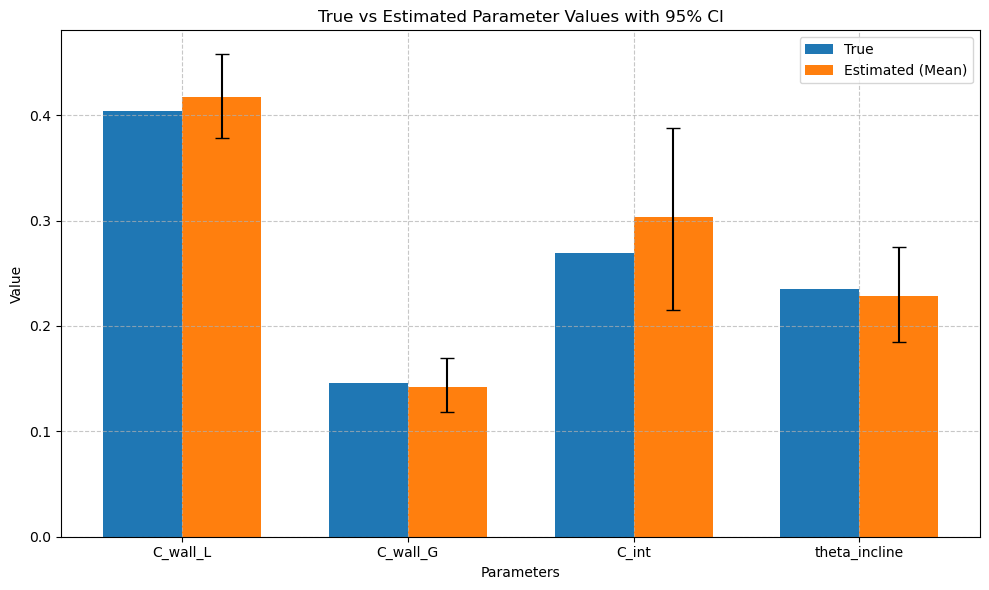

In [15]:
import pandas as pd
import numpy as np

# Analysis of inference results - comparison between true and inferred parameters

def analyze_posterior(posterior_samples, theta_true, param_names=None):
    """
    Analyze posterior samples vs true parameters
    
    Args:
        posterior_samples: torch.Tensor of samples from posterior
        theta_true: torch.Tensor of true parameter values
        param_names: list of parameter names
    
    Returns:
        DataFrame with analysis results
    """
    
    # Convert to numpy if needed
    if isinstance(posterior_samples, torch.Tensor):
        samples = posterior_samples.numpy()
    else:
        samples = posterior_samples
        
    if isinstance(theta_true, torch.Tensor):
        true_params = theta_true.numpy()
    else:
        true_params = theta_true
    
    # Make sure true_params is 1D
    if true_params.ndim > 1 and true_params.shape[0] == 1:
        true_params = true_params.flatten()
    
    # Default parameter names if none provided
    if param_names is None:
        param_names = [f"param_{i}" for i in range(samples.shape[1])]
    
    # Calculate statistics
    mean_est = np.mean(samples, axis=0)
    median_est = np.median(samples, axis=0)
    std_est = np.std(samples, axis=0)
    
    # 95% credible intervals
    ci_low = np.percentile(samples, 2.5, axis=0)
    ci_high = np.percentile(samples, 97.5, axis=0)
    
    # Calculate errors
    abs_err = np.abs(mean_est - true_params)
    rel_err = 100 * abs_err / (np.abs(true_params) + 1e-10)  # avoid div by zero
    mse = np.mean((samples - true_params)**2, axis=0)
    
    # Assemble results
    results = pd.DataFrame({
        'Parameter': param_names,
        'True': true_params,
        'Mean': mean_est,
        'Median': median_est,
        'Std': std_est,
        'CI_2.5%': ci_low,
        'CI_97.5%': ci_high,
        'Abs_Error': abs_err,
        'Rel_Error_%': rel_err,
        'MSE': mse,
        'In_CI': (true_params >= ci_low) & (true_params <= ci_high)
    })
    
    # Calculate overall metrics
    total_mse = np.mean(mse)
    avg_rel_err = np.mean(rel_err)
    params_in_ci = np.sum(results['In_CI'])
    
    print(f"Overall MSE: {total_mse:.6f}")
    print(f"Average relative error: {avg_rel_err:.2f}%")
    print(f"Parameters within 95% CI: {params_in_ci}/{len(param_names)}")
    
    return results

# Analyze posterior samples for the first inference case
param_names = ["C_wall_L", "C_wall_G", "C_int", "theta_incline"]
results = analyze_posterior(samples, theta_true, param_names)
print("\nDetailed parameter estimation results:")
display(results)

# Visualize true vs estimated parameters
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
x = np.arange(len(param_names))
width = 0.35

# Convert to numpy if needed
if isinstance(theta_true, torch.Tensor):
    true_values = theta_true.numpy()
else:
    true_values = theta_true

# Get mean estimates from posterior
if isinstance(samples, torch.Tensor):
    mean_est = samples.mean(dim=0).numpy()
else:
    mean_est = np.mean(samples, axis=0)

# Bar plot of true vs estimated
plt.bar(x - width/2, true_values, width, label='True')
plt.bar(x + width/2, mean_est, width, label='Estimated (Mean)')

# Add error bars for 95% CI
if isinstance(samples, torch.Tensor):
    ci_low = np.percentile(samples.numpy(), 2.5, axis=0)
    ci_high = np.percentile(samples.numpy(), 97.5, axis=0)
else:
    ci_low = np.percentile(samples, 2.5, axis=0)
    ci_high = np.percentile(samples, 97.5, axis=0)

plt.errorbar(x + width/2, mean_est, yerr=[mean_est - ci_low, ci_high - mean_est], 
             fmt='none', color='black', capsize=5)

plt.xlabel('Parameters')
plt.ylabel('Value')
plt.title('True vs Estimated Parameter Values with 95% CI')
plt.xticks(x, param_names)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13264/1325984797.py:19: DeprecationWarning: you passed deprecated arguments **kwargs: ['points_colors'], use fig_kwargs instead. We continue calling the deprecated pairplot function
  fig = analysis.pairplot(


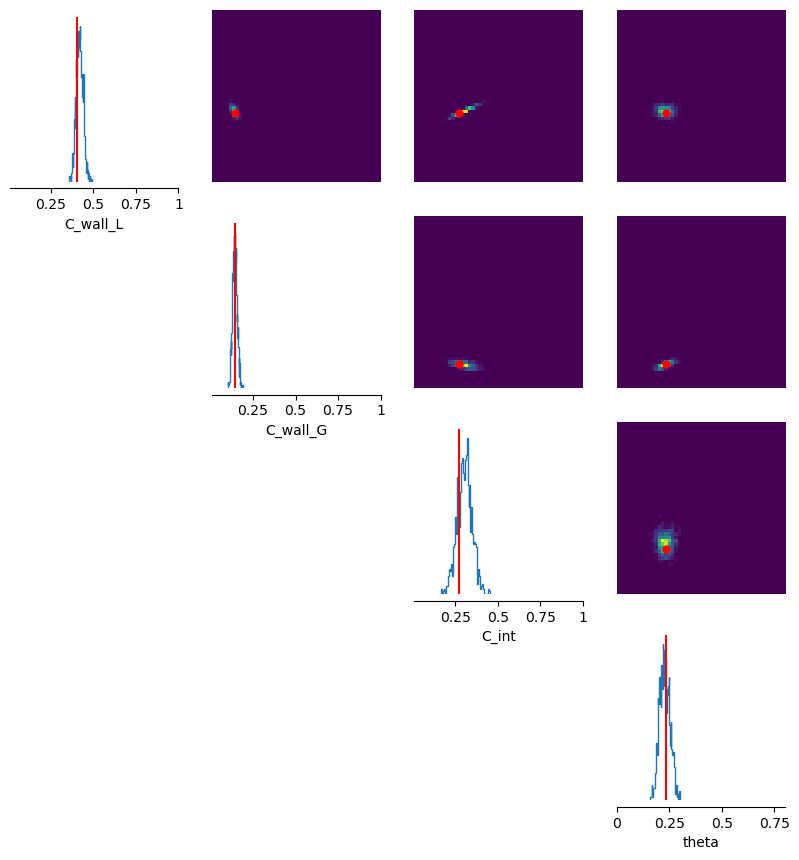

In [16]:
from sbi import analysis


# If your samples and theta_true are numpy, convert to torch
if isinstance(samples, np.ndarray):
    samples = torch.tensor(samples)
if isinstance(theta_true, np.ndarray):
    theta_true = torch.tensor(theta_true, dtype=samples.dtype)

param_names = [
    "C_wall_L", "C_wall_G", "C_int", "theta"
]

# If your observation is batched, select one (x_o)
if theta_true.ndim == 2 and theta_true.shape[0] == 1:
    theta_true = theta_true[0]

# pairplot returns the matplotlib Figure
fig = analysis.pairplot(
    samples,
    points=theta_true[None, :],  # needs shape (1, ndim)
    labels=param_names,
    points_colors="r",
    limits=limits
)

In [17]:
from scipy.ndimage import zoom

def prepare_cnn_input(array, target_shape=(32, 32)):
    """
    Downsample a 2D array [timesteps, N] to [target_shape].
    Returns a tensor of shape [1, target_shape[0], target_shape[1]] for CNN.
    """
    assert array.ndim == 2
    zoom_factors = (target_shape[0]/array.shape[0], target_shape[1]/array.shape[1])
    array_resampled = zoom(array, zoom_factors, order=1)
    return array_resampled[np.newaxis, ...]  # [1, T, N]

In [18]:
def sbi_simulator(theta):
    alpha_L, alpha_G, u_L, u_G, _ = two_phase_simulator(theta, T=1.0, N=200, L=10.0, seed=None, return_full=False)
    cnn_input = prepare_cnn_input(alpha_L, target_shape=(32, 32))  # shape [1, 32, 32]
    return cnn_input.astype(np.float32)

In [19]:
from sbi.neural_nets.embedding_nets import CNNEmbedding

embedding_net = CNNEmbedding(
    input_shape=(32, 32),
    in_channels=1,
    out_channels_per_layer=[8, 16],  # ← one per conv layer
    num_conv_layers=2,
    num_linear_layers=1,
    output_dim=8,
    kernel_size=5,
    pool_kernel_size=4
)

Drawing 2000 posterior samples: 2178it [00:00, 26922.93it/s]            


(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: xlabel='C_wall_L'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='C_wall_G'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='C_int'>, <Axes: >],
        [<Axes: xlabel='C_wall_L'>, <Axes: xlabel='C_wall_G'>,
         <Axes: xlabel='C_int'>, <Axes: xlabel='theta'>]], dtype=object))

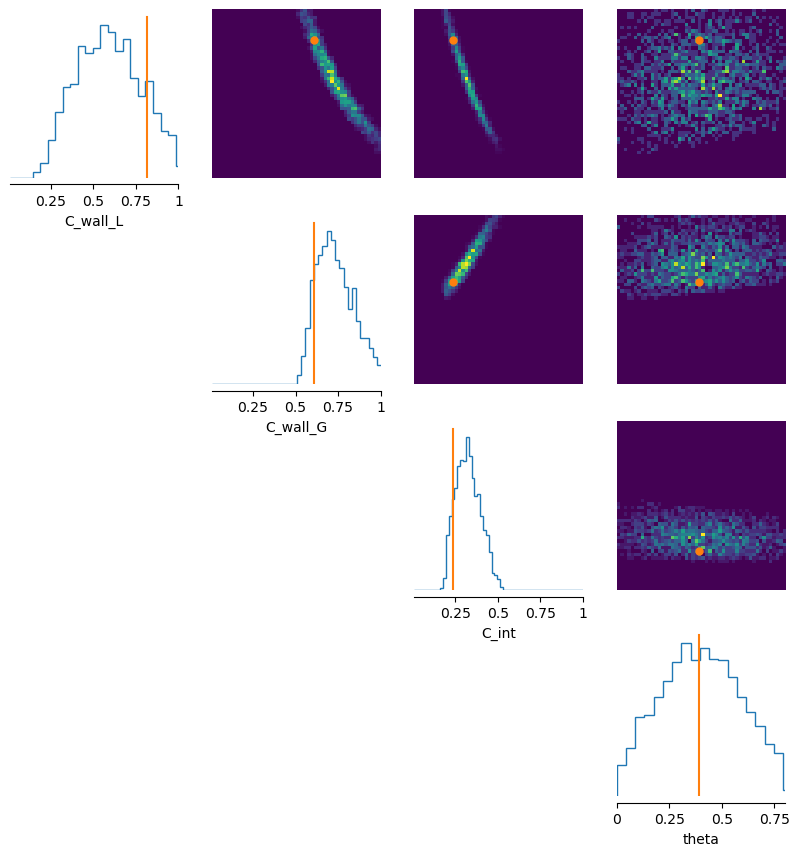

In [ ]:
import numpy as np
import torch
from sbi.inference import NPE, simulate_for_sbi
from sbi.neural_nets.embedding_nets import CNNEmbedding
from sbi.neural_nets import posterior_nn
from torch import tensor

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)

# --- Simulator and preprocessing ---

from fenics import *
def two_phase_simulator(theta, T=10.0, N=200, L=10.0, seed=None, return_full=False):
    """
    theta: [C_wall_L, C_wall_G, C_int, theta_incline]
    Returns:
        (timesteps+1, N) array of alpha_L, or optionally all fields.
    """
    # Unpack
    C_wall_L, C_wall_G, C_int, theta_pipe = map(float, theta)
    

    rho_L = 800
    rho_G = 1.2

    mesh = IntervalMesh(N, 0, L)
    dx_cell = L / N
    CFL = 0.05
    cell_centers = np.array([cell.midpoint().x() for cell in cells(mesh)])

    if seed is not None:
        np.random.seed(seed)


    # Initial holdup and velocity profiles
    V = FunctionSpace(mesh, "DG", 0)
    x = SpatialCoordinate(mesh)
    alpha_L0 = project(0.5 + 0.15 * sin(2 * np.pi * x[0] / L), V)
    alpha_G0 = project(1.0 - (0.5 + 0.15 * sin(2 * np.pi * x[0] / L)), V)


    u_L0 = 1.0 + .2 * np.sin(np.pi * cell_centers / L)
    u_G0 = 2.0 + .1 * np.cos(np.pi * cell_centers / L)

    dt = CFL * dx_cell / np.max([np.max(np.abs(u_L0)), np.max(np.abs(u_G0))])
    timesteps = int(T / dt)

    alpha_L_n = Function(V)
    alpha_G_n = Function(V)
    alpha_L_n.assign(alpha_L0)
    alpha_G_n.assign(alpha_G0)
    u_L_n = u_L0.copy()
    u_G_n = u_G0.copy()

    all_data_L = np.zeros((timesteps+1, V.dim()))
    all_data_G = np.zeros((timesteps+1, V.dim()))
    all_data_uL = np.zeros((timesteps+1, V.dim()))
    all_data_uG = np.zeros((timesteps+1, V.dim()))
    all_data_L[0, :] = alpha_L_n.vector().get_local()
    all_data_G[0, :] = alpha_G_n.vector().get_local()
    all_data_uL[0, :] = u_L_n
    all_data_uG[0, :] = u_G_n

    def compute_geometries(alpha):
        r = 0.05
        h_int = np.clip(r * (2 * alpha - 1), -r + 1e-8, r - 1e-8)
        r2 = r * r
        root_h = np.sqrt(r2 - h_int**2)
        A_L = r2 * np.arccos(-h_int/r) + h_int * root_h
        A_G = r2 * np.arccos(h_int/r) - h_int * root_h
        P_LG = 2 * root_h
        P_LW = 2 * r * np.arccos(-h_int/r)
        P_GW = 2 * r * np.arccos(h_int/r)
        return h_int, A_L, A_G, P_LG, P_LW, P_GW

    for step in range(1, timesteps+1):
        alpha_L = alpha_L_n.vector().get_local()
        alpha_G = alpha_G_n.vector().get_local()
        u_L = u_L_n.copy()
        u_G = u_G_n.copy()

        # Geometry
        h_int, A_L, A_G, P_LG, P_LW, P_GW = compute_geometries(alpha_L)
        p_int = np.full_like(alpha_L, rho_G * R * T_gas)
        # Hydrostatic pressure (linear)
        p_av_L = p_int + rho_L * g * (h_int) * np.sin(theta_pipe)
        p_av_G = p_int + rho_G * g * (h_int) * np.sin(theta_pipe)
        # Pressure gradients
        p_grad_L = np.zeros_like(p_av_L)
        p_grad_G = np.zeros_like(p_av_G)
        p_grad_L[1:-1] = (p_av_L[2:] - p_av_L[:-2]) / (2 * dx_cell)
        p_grad_G[1:-1] = (p_av_G[2:] - p_av_G[:-2]) / (2 * dx_cell)
        p_grad_L[0] = (p_av_L[1] - p_av_L[0]) / dx_cell
        p_grad_L[-1] = (p_av_L[-1] - p_av_L[-2]) / dx_cell
        p_grad_G[0] = (p_av_G[1] - p_av_G[0]) / dx_cell
        p_grad_G[-1] = (p_av_G[-1] - p_av_G[-2]) / dx_cell

        # --- ADVECT HOLDUPS (Upwind FV) ---
        F_L = np.zeros_like(alpha_L)
        F_L[1:] = A_L[1:] * u_L[1:] * alpha_L[1:]
        F_L[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        F_L_left = np.zeros_like(alpha_L)
        F_L_left[1:] = A_L[:-1] * u_L[:-1] * alpha_L[:-1]
        F_L_left[0]  = A_L[0]  * u_L[0]  * alpha_L[0]
        alpha_L_new = alpha_L - dt/dx_cell * (F_L - F_L_left) / (A_L + 1e-12)

        F_G = np.zeros_like(alpha_G)
        F_G[1:] = A_G[1:] * u_G[1:] * alpha_G[1:]
        F_G[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        F_G_left = np.zeros_like(alpha_G)
        F_G_left[1:] = A_G[:-1] * u_G[:-1] * alpha_G[:-1]
        F_G_left[0]  = A_G[0]  * u_G[0]  * alpha_G[0]
        alpha_G_new = alpha_G - dt/dx_cell * (F_G - F_G_left) / (A_G + 1e-12)

        # --- MOMENTUM (Upwind FV + drag + pressure/grav) ---
        m_L = alpha_L * rho_L * u_L
        Fm_L = np.zeros_like(m_L)
        Fm_L[1:] = A_L[1:] * (u_L[1:]**2) * alpha_L[1:] * rho_L
        Fm_L[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        Fm_L_left = np.zeros_like(m_L)
        Fm_L_left[1:] = A_L[:-1] * (u_L[:-1]**2) * alpha_L[:-1] * rho_L
        Fm_L_left[0]  = A_L[0] * (u_L[0]**2) * alpha_L[0] * rho_L
        
        gravity_L = A_L * rho_L * g * np.sin(theta_pipe)
        m_L_new = m_L \
                  - dt/dx_cell * (Fm_L - Fm_L_left) / (A_L + 1e-12) \
                  - dt * C_wall_L * m_L \
                  + dt * C_int * alpha_L * rho_L * (u_G - u_L) \
                  - dt * A_L * p_grad_L \
                  + dt * gravity_L
                  
        u_L_new = np.where(alpha_L_new > 1e-12, m_L_new / (alpha_L_new * rho_L + 1e-12), 0.0)

        m_G = alpha_G * rho_G * u_G
        Fm_G = np.zeros_like(m_G)
        Fm_G[1:] = A_G[1:] * (u_G[1:]**2) * alpha_G[1:] * rho_G
        Fm_G[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G
        Fm_G_left = np.zeros_like(m_G)
        Fm_G_left[1:] = A_G[:-1] * (u_G[:-1]**2) * alpha_G[:-1] * rho_G
        Fm_G_left[0]  = A_G[0] * (u_G[0]**2) * alpha_G[0] * rho_G


        gravity_G = A_G * rho_G * g * np.sin(theta_pipe)

        m_G_new = m_G \
                  - dt/dx_cell * (Fm_G - Fm_G_left) / (A_G + 1e-12) \
                  - dt * C_wall_G * m_G \
                  - dt * C_int * alpha_G * rho_G * (u_G - u_L) \
                  - dt * A_G * p_grad_G \
                  + dt * gravity_G

        u_G_new = np.where(alpha_G_new > 1e-12, m_G_new / (alpha_G_new * rho_G + 1e-12), 0.0)

        # --- ENFORCE CLOSURE ---
        sum_holdup = alpha_L_new + alpha_G_new
        alpha_L_new /= (sum_holdup + 1e-12)
        alpha_G_new /= (sum_holdup + 1e-12)

        # Save and update
        alpha_L_n.vector().set_local(alpha_L_new)
        alpha_G_n.vector().set_local(alpha_G_new)
        u_L_n = u_L_new
        u_G_n = u_G_new
        all_data_L[step, :] = alpha_L_new
        all_data_G[step, :] = alpha_G_new
        all_data_uL[step, :] = u_L_new
        all_data_uG[step, :] = u_G_new


    return all_data_L

# -- Downsampling for CNNEmbedding --
from scipy.ndimage import zoom

def prepare_cnn_input(array, target_shape=(32, 32)):
    zoom_factors = (target_shape[0]/array.shape[0], target_shape[1]/array.shape[1])
    array_resampled = zoom(array, zoom_factors, order=1)
    return array_resampled[np.newaxis, ...].astype(np.float32)  # [1, T, N]

# -- Simulator wrapper for sbi --
def sbi_simulator(theta):
    arr = two_phase_simulator(theta, T=10.0, N=200, L=10.0)
    arr = prepare_cnn_input(arr, target_shape=(32, 32))
    return arr

# -- Define prior (for 3 params as example) --
from sbi.utils import BoxUniform
low = torch.tensor([0.01, 0.01, 0.01, 0.0])
high = torch.tensor([1., 1., 1., 0.8])
prior = BoxUniform(low=low, high=high)

limits = [[l, h] for l, h in zip(low, high)]

# -- CNN embedding net --
embedding_net = CNNEmbedding(
    input_shape=(32, 32),
    in_channels=1,
    out_channels_per_layer=[8, 16],  # ← one per conv layer
    num_conv_layers=2,
    num_linear_layers=1,
    output_dim=8,
    kernel_size=5,
    pool_kernel_size=4
)

# -- SBI with SNPE --

prior, num_parameters, prior_returns_numpy = process_prior(prior)
simulator = process_simulator(sbi_simulator, prior, prior_returns_numpy)
check_sbi_inputs(simulator, prior)

density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

# -- Simulate --
num_simulations = 4000
theta, x = simulate_for_sbi(simulator, prior, num_simulations=num_simulations)

# -- Train --
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior()

# -- Inference: sample posterior at true parameters --
# true_theta = torch.tensor([0.005, 0.004, 0.01, 1000, 0.4])
true_theta = torch.tensor([0.8155, 0.6099, 0.2382, 0.3897])
x_o = torch.tensor(sbi_simulator(true_theta.numpy()))
posterior_samples = posterior.sample((2000,), x=x_o)

# -- Visualize pairplot
from sbi.analysis import pairplot
pairplot(posterior_samples, points=true_theta.unsqueeze(0), labels=["C_wall_L", "C_wall_G", "C_int", "theta"], limits=limits)


Evaluation of first inference case:
Overall MSE: 0.039688
Average relative error: 21.48%
Average normalized RMSE: 20.12%
Parameters within 95% CI: 4/4


,Parameter,True,Mean,Median,Std,CI_2.5%,CI_97.5%,Abs_Error,Rel_Error_%,MSE,NRMSE_%,In_CI
0,C_wall_L,0.8155,0.591344,0.586389,0.186367,0.262061,0.950408,0.224156,27.486898,0.084979,29.445564,True
1,C_wall_G,0.6099,0.732467,0.719472,0.107141,0.559889,0.961009,0.122567,20.096313,0.026502,16.443773,True
2,C_int,0.2382,0.324263,0.319350,0.071223,0.202556,0.468051,0.086063,36.130604,0.012480,11.284041,True
3,theta_incline,0.3897,0.398309,0.396961,0.186328,0.057279,0.753285,0.008609,2.209134,0.034792,23.315886,True


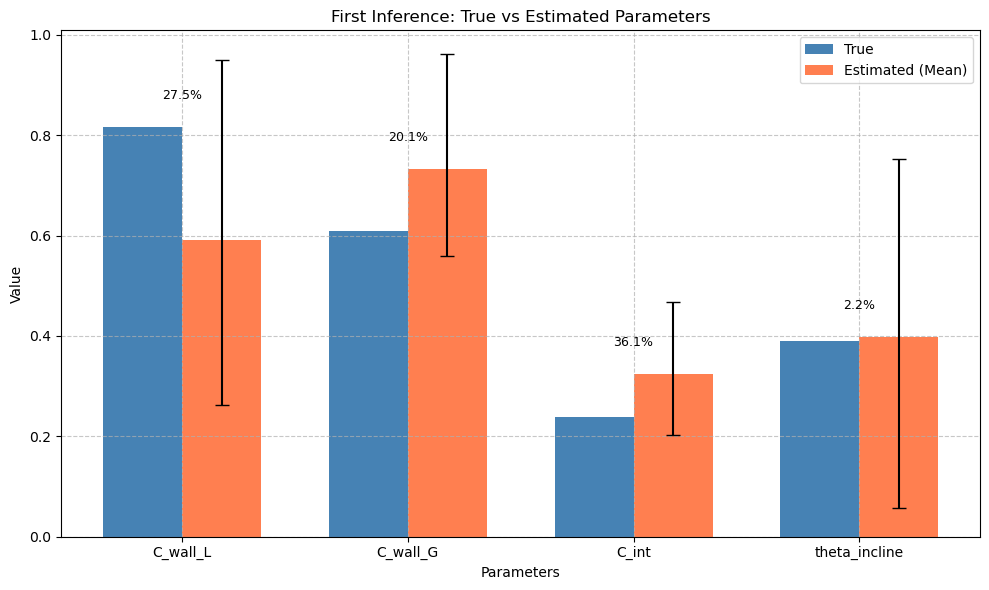

In [15]:
def evaluate_posterior(samples, theta_true, param_names=None):
    """
    Evaluate the posterior samples against the true parameter values.
    
    Args:
        samples: torch.Tensor of samples from posterior
        theta_true: torch.Tensor of true parameter values
        param_names: list of parameter names
    
    Returns:
        DataFrame with evaluation metrics
    """
    # Convert to numpy if needed
    if isinstance(samples, torch.Tensor):
        samples_np = samples.numpy()
    else:
        samples_np = samples
        
    if isinstance(theta_true, torch.Tensor):
        true_params = theta_true.numpy()
    else:
        true_params = theta_true
    
    # Make sure true_params is 1D
    if true_params.ndim > 1 and true_params.shape[0] == 1:
        true_params = true_params.flatten()
    
    # Default parameter names if none provided
    if param_names is None:
        param_names = [f"param_{i}" for i in range(samples_np.shape[1])]
    
    # Calculate metrics
    mean_est = np.mean(samples_np, axis=0)
    median_est = np.median(samples_np, axis=0)
    std_est = np.std(samples_np, axis=0)
    
    # 95% credible intervals
    ci_low = np.percentile(samples_np, 2.5, axis=0)
    ci_high = np.percentile(samples_np, 97.5, axis=0)
    
    # Calculate errors
    abs_err = np.abs(mean_est - true_params)
    rel_err = 100 * abs_err / (np.abs(true_params) + 1e-10)
    mse = np.mean((samples_np - true_params.reshape(1, -1))**2, axis=0)
    
    # Calculate normalized RMSE (as percentage of parameter range)
    param_ranges = np.array([(h-l) for l, h in limits]).flatten()
    nrmse = 100 * np.sqrt(mse) / param_ranges
    
    # Metrics for the entire posterior
    total_mse = np.mean(mse)
    avg_rel_err = np.mean(rel_err)
    avg_nrmse = np.mean(nrmse)
    
    # Check if true parameter is within 95% CI
    in_ci = (true_params >= ci_low) & (true_params <= ci_high)
    params_in_ci = np.sum(in_ci)
    
    # Create summary table
    results = pd.DataFrame({
        'Parameter': param_names,
        'True': true_params,
        'Mean': mean_est,
        'Median': median_est,
        'Std': std_est,
        'CI_2.5%': ci_low,
        'CI_97.5%': ci_high,
        'Abs_Error': abs_err,
        'Rel_Error_%': rel_err,
        'MSE': mse,
        'NRMSE_%': nrmse,
        'In_CI': in_ci
    })
    
    # Print summary statistics
    print(f"Overall MSE: {total_mse:.6f}")
    print(f"Average relative error: {avg_rel_err:.2f}%")
    print(f"Average normalized RMSE: {avg_nrmse:.2f}%")
    print(f"Parameters within 95% CI: {params_in_ci}/{len(param_names)}")
    
    return results

# Evaluate the posterior for both inference examples
print("Evaluation of first inference case:")
results1 = evaluate_posterior(posterior_samples, true_theta, param_names)
display(results1)

# print("\nEvaluation of second inference case:")
# results2 = evaluate_posterior(posterior_samples, true_theta_2, param_names)
# display(results2)

# Create a bar plot comparing true vs estimated parameters with error bars
def plot_parameter_comparison(results, title="True vs Estimated Parameters"):
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(results['Parameter']))
    width = 0.35
    
    # Plot bars
    ax.bar(x - width/2, results['True'], width, label='True', color='steelblue')
    ax.bar(x + width/2, results['Mean'], width, label='Estimated (Mean)', color='coral')
    
    # Add error bars
    err_minus = results['Mean'] - results['CI_2.5%']
    err_plus = results['CI_97.5%'] - results['Mean']
    ax.errorbar(x + width/2, results['Mean'], yerr=[err_minus, err_plus], 
                fmt='none', color='black', capsize=5)
    
    # Add parameter names and other decorations
    ax.set_xlabel('Parameters')
    ax.set_ylabel('Value')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(results['Parameter'])
    ax.legend()
    
    # Add relative error as text above bars
    for i, (true_val, est_val, rel_err) in enumerate(zip(results['True'], 
                                                      results['Mean'], 
                                                      results['Rel_Error_%'])):
        y_pos = max(true_val, est_val) + 0.05
        ax.text(i, y_pos, f"{rel_err:.1f}%", ha='center', va='bottom', 
                fontsize=9, rotation=0)
    
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    return fig

# Plot results for the first inference case
fig1 = plot_parameter_comparison(results1, title="First Inference: True vs Estimated Parameters")
plt.show()

# # Plot results for the second inference case
# fig2 = plot_parameter_comparison(results2, title="Second Inference: True vs Estimated Parameters")
# plt.show()

/tmp/ipykernel_13264/1449500730.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  true_theta_2 = torch.tensor(prior.sample([1,]).flatten())
Drawing 2000 posterior samples: 2215it [00:00, 63617.95it/s]            


(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: xlabel='C_wall_L'>, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='C_wall_G'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='C_int'>, <Axes: >],
        [<Axes: xlabel='C_wall_L'>, <Axes: xlabel='C_wall_G'>,
         <Axes: xlabel='C_int'>, <Axes: xlabel='rho_L'>]], dtype=object))

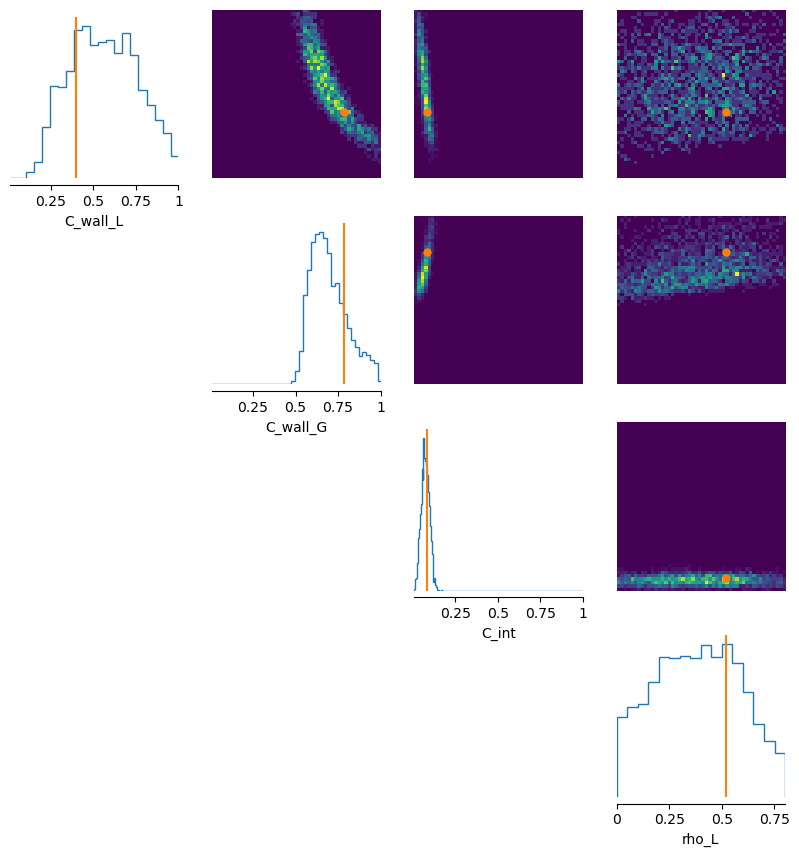

In [21]:
# -- Inference: sample posterior at true parameters --
true_theta_2 = torch.tensor(prior.sample([1,]).flatten())
x_o_2 = torch.tensor(sbi_simulator(true_theta_2))
posterior_samples = posterior.sample((2000,), x=x_o_2)



# -- Visualize pairplot
from sbi.analysis import pairplot
pairplot(posterior_samples, points=true_theta_2.unsqueeze(0), labels=["C_wall_L", "C_wall_G", "C_int", "rho_L", "theta"], limits=limits)